# [DACON] 인공지능 비트 트레이더 경진대회

> 비트코인이 포함된 10가지 종류의 암호화폐 가격을 예측하여 가장 높은 수익율을 갖는 모델을 만들어 주세요!</br>
모든 참가자 분들은 총 10,000달러의 가상 자본금을 갖고있습니다.</br>
총 529건의 투자기회에서 연속적으로 투자를 하고 최종 변동 금액을 예측하는 모델을 만드는 것을 목표로 합니다.</br>

## 0. 데이터, 모듈 불러오기

In [2]:
!pip install pingouin

     |████████████████████████████████| 204kB 8.7MB/s 
  Created wheel for pingouin: filename=pingouin-0.3.10-cp37-none-any.whl size=203396 sha256=caf68f9d2dbcdd0c850c83209098111407b0d3852492e7ab040da12210af52d0
  Stored in directory: /root/.cache/pip/wheels/e6/f4/06/b5046209e6c0d96b4dea243c45e926b5c0dd88e23b01c45f92
  Created wheel for outdated: filename=outdated-0.2.0-cp37-none-any.whl size=4962 sha256=e58e7ae559acd434e12b9d41ab417b3612872b4320b40a7df4454eb9020dc13e
  Stored in directory: /root/.cache/pip/wheels/fd/7c/ef/814f514d31197310872b5abf353feb8fef9d67ee658e1e7e39
  Created wheel for littleutils: filename=littleutils-0.2.2-cp37-none-any.whl size=7051 sha256=9772bdec7bb9594499ce6af60b279accdeb321e5555f8b725371d0508d92795a
  Stored in directory: /root/.cache/pip/wheels/53/16/9f/ac67d15c40243754fd73f620e1b9b6dedc20492ecc19a2bae1
Successfully built pingouin outdated littleutils


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
from pingouin import welch_anova

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [41]:
train_x = pd.read_csv('/content/drive/MyDrive/비트 트레이더/open/train_x_df.csv')
train_y = pd.read_csv('/content/drive/MyDrive/비트 트레이더/open/train_y_df.csv')

In [42]:
train_x.head()

,sample_id,time,coin_index,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av
0,0,0,7,1.010004,1.010004,1.009612,1.010004,8.382875e+05,43160.632812,451.157288,7.326834e+05,37725.183594
1,0,1,7,1.009808,1.009808,1.009808,1.009808,1.622420e+05,8352.220703,39.231071,0.000000e+00,0.000000
2,0,2,7,1.009808,1.010200,1.009808,1.010200,1.664967e+04,857.377808,58.846603,1.664967e+04,857.377808
3,0,3,7,1.010200,1.011181,1.010200,1.011181,2.586971e+06,133310.343750,431.541779,2.189147e+06,112811.046875
4,0,4,7,1.010985,1.010985,1.010200,1.010200,1.129996e+06,58216.867188,176.539810,0.000000e+00,0.000000


In [43]:
train_y.head()

,sample_id,time,coin_index,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av
0,0,0,7,1.000392,1.000588,1.000392,1.000588,8.305119e+05,42356.179688,137.308746,8.305119e+05,42356.179688
1,0,1,7,1.000588,1.001177,1.000392,1.001177,5.320066e+05,27140.638672,294.233032,4.882738e+05,24909.861328
2,0,2,7,1.001177,1.001177,1.001177,1.001177,5.113770e+05,26100.681641,58.846603,5.113770e+05,26100.681641
3,0,3,7,1.001177,1.001373,1.001177,1.001373,1.134853e+06,57929.410156,137.308746,1.095514e+06,55921.156250
4,0,4,7,1.000981,1.000981,0.999804,1.000196,5.801173e+06,295872.343750,666.928162,9.911239e+05,50528.589844


## 1. 데이터 파악하기 

#### 결측치 확인

In [44]:
train_x.isna().sum()

sample_id      0
time           0
coin_index     0
open           0
high           0
low            0
close          0
volume         0
quote_av       0
trades         0
tb_base_av     0
tb_quote_av    0
dtype: int64

In [45]:
train_y.isna().sum()

sample_id      0
time           0
coin_index     0
open           0
high           0
low            0
close          0
volume         0
quote_av       0
trades         0
tb_base_av     0
tb_quote_av    0
dtype: int64

#### shape 확인

In [46]:
train_x.shape

(10159560, 12)

In [47]:
train_y.shape

(883440, 12)

#### 변수 확인

- sample_id : 개별 샘플의 인덱스
- time : x_df는 0분 ~ 1379분(처음 23시간), y_df는 0분 ~ 119분(끝 2시간)의 값을 갖습니다. 동일한 샘플 내 시간 정보
- coin_index : 10가지 종류의 코인에 대한 비식별화 인덱스 (0 ~9)
- open : open price
- high : high price
- low : low price
- close : close price
- volume : 거래량
- quote_av : quote asset volume
- trades : 거래 건 수
- tb_base_av : taker buy base asset volume
- tb_quote_av : taker buy quote asset volume

#### 데이터 형태 확인

In [48]:
train_x.groupby('sample_id').count()

,time,coin_index,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av
sample_id,,,,,,,,,,,
0,1380,1380,1380,1380,1380,1380,1380,1380,1380,1380,1380
1,1380,1380,1380,1380,1380,1380,1380,1380,1380,1380,1380
2,1380,1380,1380,1380,1380,1380,1380,1380,1380,1380,1380
3,1380,1380,1380,1380,1380,1380,1380,1380,1380,1380,1380
4,1380,1380,1380,1380,1380,1380,1380,1380,1380,1380,1380
...,...,...,...,...,...,...,...,...,...,...,...
7357,1380,1380,1380,1380,1380,1380,1380,1380,1380,1380,1380
7358,1380,1380,1380,1380,1380,1380,1380,1380,1380,1380,1380
7359,1380,1380,1380,1380,1380,1380,1380,1380,1380,1380,1380


**=> sample_id 7362개**

In [49]:
train_x.groupby(['coin_index','sample_id']).count()

time  open  high  ...  trades  tb_base_av  tb_quote_av
coin_index sample_id                    ...                                 
0          1          1380  1380  1380  ...    1380        1380         1380
           16         1380  1380  1380  ...    1380        1380         1380
           19         1380  1380  1380  ...    1380        1380         1380
           26         1380  1380  1380  ...    1380        1380         1380
           30         1380  1380  1380  ...    1380        1380         1380
...                    ...   ...   ...  ...     ...         ...          ...
9          7351       1380  1380  1380  ...    1380        1380         1380
           7353       1380  1380  1380  ...    1380        1380         1380
           7354       1380  1380  1380  ...    1380        1380         1380
           7356       1380  1380  1380  ...    1380        1380         1380
           7358       1380  1380  1380  ...    1380        1380         1380

[7362 rows x 10 columns]

**=> 'coin_index'는 코인의 종류, 'sample_id'는 개별 코인을 의미**

## 2. EDA

#### 시계열 그래프 확인 (sample_id == 0)

In [50]:
x_sample_0 = train_x[train_x['sample_id']==0]
y_sample_0 = train_y[train_y['sample_id']==0]

In [51]:
x_sample_0.shape

(1380, 12)

In [52]:
y_sample_0.shape

(120, 12)

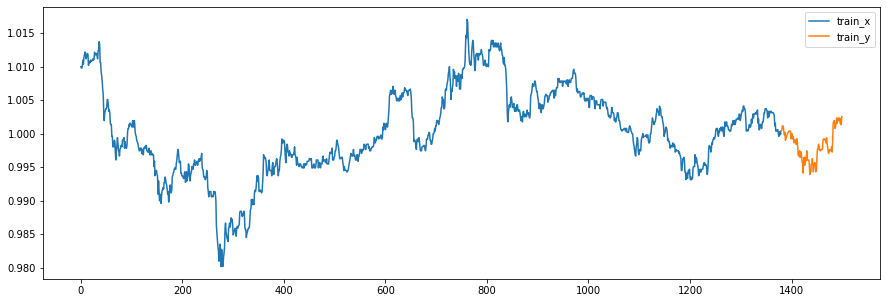

In [53]:
# open price 기준

plt.figure(figsize = (15,5))
plt.plot(x_sample_0['open'], label = 'train_x')
plt.plot(np.arange(x_sample_0.shape[0], x_sample_0.shape[0]+y_sample_0.shape[0]), y_sample_0['open'], label = 'train_y')
plt.legend()
plt.show()

#### 변동률 확인 (분 단위)

((당일 종가)-(전일 종가))/전일 종가 </br>
참고) 원래 일 단위별 변동률은 당일 고가에서 당일 저가를 뺀 수치를 전일 종가로 나누어 구한다.

In [54]:
x_sample_0['fluct_rate']= float(0)
y_sample_0['fluct_rate']= float(0)

for i in range(len(x_sample_0)-1):
    x_sample_0['fluct_rate'][i+1] = (x_sample_0['close'][i+1]-x_sample_0['close'][i])/x_sample_0['close'][i]

for i in range(len(y_sample_0)-1):
    y_sample_0['fluct_rate'][i+1] = (y_sample_0['close'][i+1]-y_sample_0['close'][i])/y_sample_0['close'][i]

x_sample_0.head(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

,sample_id,time,coin_index,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av,fluct_rate
0,0,0,7,1.010004,1.010004,1.009612,1.010004,8.382875e+05,43160.632812,451.157288,7.326834e+05,37725.183594,0.000000
1,0,1,7,1.009808,1.009808,1.009808,1.009808,1.622420e+05,8352.220703,39.231071,0.000000e+00,0.000000,-0.000194
2,0,2,7,1.009808,1.010200,1.009808,1.010200,1.664967e+04,857.377808,58.846603,1.664967e+04,857.377808,0.000389
3,0,3,7,1.010200,1.011181,1.010200,1.011181,2.586971e+06,133310.343750,431.541779,2.189147e+06,112811.046875,0.000971
4,0,4,7,1.010985,1.010985,1.010200,1.010200,1.129996e+06,58216.867188,176.539810,0.000000e+00,0.000000,-0.000970
5,0,5,7,1.010396,1.011377,1.010396,1.011377,1.226671e+06,63211.722656,255.001953,1.226671e+06,63211.722656,0.001165
6,0,6,7,1.011377,1.011769,1.011377,1.011769,1.658297e+05,8552.825195,78.462143,1.567674e+05,8085.568359,0.000388
7,0,7,7,1.011769,1.011769,1.011769,1.011769,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000
8,0,8,7,1.012162,1.012162,1.012162,1.012162,1.019949e+05,5262.937012,39.231071,3.663005e+04,1890.110596,0.000388
9,0,9,7,1.012162,1.012162,1.010789,1.010985,1.392534e+06,71794.312500,294.233032,4.946646e+05,25505.400391,-0.001163


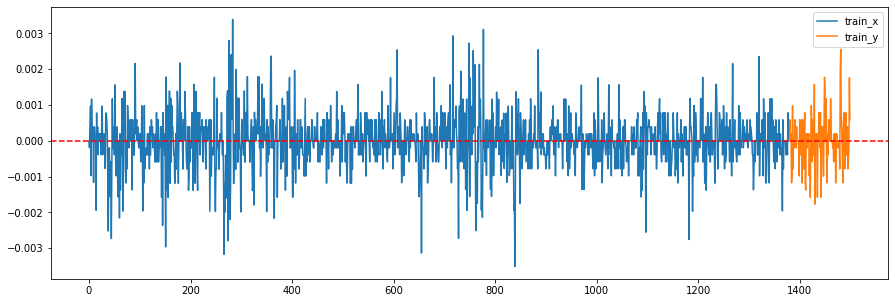

In [55]:
plt.figure(figsize = (15,5))
plt.plot(x_sample_0['fluct_rate'], label = 'train_x')
plt.plot(np.arange(x_sample_0.shape[0], x_sample_0.shape[0]+y_sample_0.shape[0]), y_sample_0['fluct_rate'], label = 'train_y')
plt.legend()
plt.axhline( y = 0, color = 'red', ls = '--')
plt.show()

#### 코인 인덱스 그룹 별 데이터 평균치

In [56]:
train_x_ = train_x.copy()

In [57]:
train_x_.groupby('coin_index').mean()

,sample_id,time,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av
coin_index,,,,,,,,,,,
0,3638.785006,689.5,1.001860,1.002574,1.001126,1.001854,2.068114e+03,6895.755024,14.950617,1.053568e+03,3574.743175
1,3685.445026,689.5,1.000512,1.001248,0.999764,1.000510,4.754299e-01,125.372142,0.294254,2.346630e-01,61.922350
2,3821.059406,689.5,0.997462,0.998998,0.995908,0.997467,3.020080e+03,11245.539148,26.567277,1.470193e+03,5483.210560
3,3638.023256,689.5,0.997814,0.998849,0.996733,0.997821,1.522021e+03,7319.138709,14.079154,7.625896e+02,3666.690156
4,3744.067742,689.5,1.001291,1.002030,1.000523,1.001284,4.221608e+05,125581.495921,258.879942,2.089920e+05,62427.957998
5,3563.137615,689.5,1.004781,1.005419,1.004097,1.004750,5.403057e+06,62644.491171,326.565377,2.494798e+06,29447.162735
6,3636.358685,689.5,1.000878,1.001731,1.000004,1.000870,5.005970e+00,305.405591,0.718290,2.489654e+00,151.985876
7,3751.730729,689.5,1.000556,1.001324,0.999752,1.000544,2.426671e+06,162866.742656,454.210633,1.193621e+06,80560.207882
8,3704.675722,689.5,1.000680,1.001496,0.999839,1.000672,1.408839e+00,310.638500,0.531346,7.075279e-01,155.924650


#### '코인의 종류(범주형)'와 '변동정도(연속형)'간의 ANOVA

- https://junsik-hwang.tistory.com/27
- https://alex-blog.tistory.com/entry/%EB%8D%B0%EC%9D%B4%ED%84%B0-%EB%B6%84%EC%84%9D%EC%9D%84-%EC%9C%84%ED%95%9C-%ED%86%B5%EA%B3%84%EB%B6%84%EC%84%9DANOVA-feat-python

In [58]:
# 상한가에서 하한가를 빼어 분당 변동정도를 나타내는 'fluct' 변수 생성
train_x_['fluct'] = train_x_['high']-train_x_['low']
train_x_.head()

,sample_id,time,coin_index,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av,fluct
0,0,0,7,1.010004,1.010004,1.009612,1.010004,8.382875e+05,43160.632812,451.157288,7.326834e+05,37725.183594,0.000392
1,0,1,7,1.009808,1.009808,1.009808,1.009808,1.622420e+05,8352.220703,39.231071,0.000000e+00,0.000000,0.000000
2,0,2,7,1.009808,1.010200,1.009808,1.010200,1.664967e+04,857.377808,58.846603,1.664967e+04,857.377808,0.000392
3,0,3,7,1.010200,1.011181,1.010200,1.011181,2.586971e+06,133310.343750,431.541779,2.189147e+06,112811.046875,0.000981
4,0,4,7,1.010985,1.010985,1.010200,1.010200,1.129996e+06,58216.867188,176.539810,0.000000e+00,0.000000,0.000785


In [59]:
train_x_.groupby('coin_index').mean().fluct

coin_index
0    0.001448
1    0.001485
2    0.003090
3    0.002117
4    0.001507
5    0.001322
6    0.001727
7    0.001572
8    0.001657
9    0.001356
Name: fluct, dtype: float64

In [60]:
# 'coin index'칼럼의 데이터 타입확인
train_x_['coin_index'].dtype

dtype('int64')

In [61]:
# 범주형으로 바꿔준다!
train_x_['coin_index'] = train_x_['coin_index'].astype('category')
train_x_['coin_index'].dtype

CategoricalDtype(categories=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], ordered=False)

In [62]:
x0 = np.array(train_x_[train_x_.coin_index == 0].fluct)
x1 = np.array(train_x_[train_x_.coin_index == 1].fluct)
x2 = np.array(train_x_[train_x_.coin_index == 2].fluct)
x3 = np.array(train_x_[train_x_.coin_index == 3].fluct)
x4 = np.array(train_x_[train_x_.coin_index == 4].fluct)
x5 = np.array(train_x_[train_x_.coin_index == 5].fluct)
x6 = np.array(train_x_[train_x_.coin_index == 6].fluct)
x7 = np.array(train_x_[train_x_.coin_index == 7].fluct)
x8 = np.array(train_x_[train_x_.coin_index == 8].fluct)
x9 = np.array(train_x_[train_x_.coin_index == 9].fluct)

In [63]:
F_statistic, pVal = stats.f_oneway(x0, x1, x2, x3, x4, x5, x6, x7, x8, x9)
print('데이터의 일원분산분석 결과 : F=%.2f , p=%.10f ' %(F_statistic, pVal))

데이터의 일원분산분석 결과 : F=9689.64 , p=0.0000000000 


In [64]:
# 정규성 가정을 충족하지 않았을 때
stats.kruskal(x0, x1, x2, x3, x4, x5, x6, x7, x8, x9)

KruskalResult(statistic=676556.3274807257, pvalue=0.0)

In [65]:
# 등분산성 가정을 충족하지 않았을 때
aov = welch_anova(dv='fluct', between='coin_index', data=train_x_) 
aov

,Source,ddof1,ddof2,F,p-unc,np2
0,coin_index,9,1.761514e+06,5424.182271,0.0,0.008511


**=> 모든 경우에서 'coin_index' 간에 유의미한 차이가 있음을 나타냄!**

#### 연속형 변수들의 상관계수 확인

In [66]:
train_x__ = train_x_.copy()

In [67]:
# 상관행렬
train_x__.drop(['time','sample_id','coin_index'], axis = 1, inplace=True) # 'time','sample_id' 칼럼은 drop
corr_df = train_x__.corr()
corr_df

,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av,fluct
open,1.000000,0.998631,0.999254,0.999071,0.009158,0.025290,0.022769,0.004867,0.019132,0.030392
high,0.998631,1.000000,0.997830,0.998898,0.014944,0.033986,0.032518,0.011817,0.029751,0.072756
low,0.999254,0.997830,1.000000,0.999315,0.002101,0.014780,0.011092,0.001434,0.012224,0.006923
close,0.999071,0.998898,0.999315,1.000000,0.008074,0.024175,0.021432,0.007229,0.022276,0.033522
volume,0.009158,0.014944,0.002101,0.008074,1.000000,0.420857,0.573042,0.794751,0.372958,0.195106
quote_av,0.025290,0.033986,0.014780,0.024175,0.420857,1.000000,0.826307,0.344711,0.920649,0.292242
trades,0.022769,0.032518,0.011092,0.021432,0.573042,0.826307,1.000000,0.466903,0.754661,0.325820
tb_base_av,0.004867,0.011817,0.001434,0.007229,0.794751,0.344711,0.466903,1.000000,0.425748,0.157734
tb_quote_av,0.019132,0.029751,0.012224,0.022276,0.372958,0.920649,0.754661,0.425748,1.000000,0.266652
fluct,0.030392,0.072756,0.006923,0.033522,0.195106,0.292242,0.325820,0.157734,0.266652,1.000000


주목할 부분은
- open-high-low-close
- trades-(tb_base_av,tb_quote_av)
- volume-tb_vase_av

## 3. LSTM(Keras) 적용

In [68]:
train_x[train_x['coin_index']==7]['sample_id'].unique()

array([   0,   15,   18,   22,   25,   33,   35,   45,   63,   67,   74,
         77,   88,  100,  112,  120,  122,  136,  142,  150,  165,  178,
        196,  205,  225,  237,  279,  289,  299,  306,  307,  311,  330,
        334,  341,  357,  362,  363,  376,  392,  393,  398,  404,  406,
        417,  418,  432,  442,  444,  447,  472,  475,  479,  482,  484,
        496,  503,  510,  527,  531,  533,  535,  547,  548,  557,  560,
        564,  568,  580,  585,  586,  592,  605,  613,  617,  622,  629,
        632,  651,  654,  670,  684,  685,  694,  697,  703,  714,  715,
        716,  738,  740,  751,  761,  769,  784,  788,  791,  793,  796,
        807,  812,  822,  843,  844,  854,  855,  864,  873,  879,  887,
        892,  898,  901,  906,  908,  912,  920,  928,  932,  935,  953,
        954,  964,  965,  967,  983, 1003, 1030, 1032, 1039, 1042, 1047,
       1052, 1054, 1055, 1056, 1059, 1060, 1061, 1088, 1092, 1095, 1105,
       1106, 1112, 1113, 1114, 1121, 1125, 1128, 11

**=> coin_index가 7인 0번, 15번, 18번 데이터를 써보자**

In [102]:
'''
# train: 0번 샘플, val: 15번 샘플, test: 18번 샘플
Train_x = train_x[train_x['sample_id']==0]
Train_y = train_y[train_y['sample_id']==0]
Val_x = train_x[train_x['sample_id']==15]
Val_y = train_y[train_y['sample_id']==15]
Test_x = train_x[train_x['sample_id']==18]
Test_y = train_y[train_y['sample_id']==18]

print(Train_x.shape, Val_x.shape, Test_x.shape)
'''

(1380, 12) (1380, 12) (1380, 12)


#### 데이터 스케일링

In [103]:
'''
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
cols = ['open', 'high', 'low', 'close', 'volume']

# train
Train_x_scaled = scaler.fit_transform(Train_x[cols])
Train_x_df = pd.DataFrame(Train_x_scaled)
Train_x_df.columns = cols
Train_y_scaled = scaler.fit_transform(Train_y[cols])
Train_y_df = pd.DataFrame(Train_y_scaled)
Train_y_df.columns = cols

# val
Val_x_scaled = scaler.fit_transform(Val_x[cols])
Val_x_df = pd.DataFrame(Val_x_scaled)
Val_x_df.columns = cols
Val_y_scaled = scaler.fit_transform(Val_y[cols])
Val_y_df = pd.DataFrame(Val_y_scaled)
Val_y_df.columns = cols

# test
Test_x_scaled = scaler.fit_transform(Test_x[cols])
Test_x_df = pd.DataFrame(Test_x_scaled)
Test_x_df.columns = cols
Test_y_scaled = scaler.fit_transform(Test_y[cols])
Test_y_df = pd.DataFrame(Test_y_scaled)
Test_y_df.columns = cols
'''

"\nfrom sklearn.preprocessing import MinMaxScaler\n\nscaler = MinMaxScaler()\ncols = ['open', 'high', 'low', 'close', 'volume']\n\n# train\nTrain_x_scaled = scaler.fit_transform(Train_x[cols])\nTrain_x_df = pd.DataFrame(Train_x_scaled)\nTrain_x_df.columns = cols\nTrain_y_scaled = scaler.fit_transform(Train_y[cols])\nTrain_y_df = pd.DataFrame(Train_y_scaled)\nTrain_y_df.columns = cols\n\n# val\nVal_x_scaled = scaler.fit_transform(Val_x[cols])\nVal_x_df = pd.DataFrame(Val_x_scaled)\nVal_x_df.columns = cols\nVal_y_scaled = scaler.fit_transform(Val_y[cols])\nVal_y_df = pd.DataFrame(Val_y_scaled)\nVal_y_df.columns = cols\n\n# test\nTest_x_scaled = scaler.fit_transform(Test_x[cols])\nTest_x_df = pd.DataFrame(Test_x_scaled)\nTest_x_df.columns = cols\nTest_y_scaled = scaler.fit_transform(Test_y[cols])\nTest_y_df = pd.DataFrame(Test_y_scaled)\nTest_y_df.columns = cols\n"

#### 3차원으로 변경

In [104]:
# 입력 받은 2차원 데이터 프레임을 3차원 numpy array로 변경하는 함수

def df2d_to_array3d(df_2d):
 
    feature_size = df_2d.iloc[:,2:].shape[1]
    time_size = len(df_2d.time.value_counts())
    sample_size = len(df_2d.sample_id.value_counts())
    sample_index = df_2d.sample_id.value_counts().index
    array_3d = df_2d.iloc[:,2:].values.reshape([sample_size, time_size, feature_size])
    return array_3d

In [111]:
data = train_x[train_x['coin_index']==7]


In [ ]:
train = data.loc[:801, ]
val = data.loc[801:947, ] 
test = data.loc[947:948, ] # 마지막 하나만 test

In [ ]:
train_arr = df2d_to_array3d(trai)

In [105]:
'''
train_x_arr = df2d_to_array3d(Train_x)
train_y_arr = df2d_to_array3d(Train_y)
val_x_arr = df2d_to_array3d(Val_x)
val_y_arr = df2d_to_array3d(Val_y)
test_x_arr = df2d_to_array3d(Test_x)
test_y_arr = df2d_to_array3d(Test_y)
'''

In [106]:
#train_x_arr.shape

(1, 1380, 10)

In [108]:
#train_y_arr.shape

(1, 120, 10)

In [107]:
'''
Train_y.drop(['time','sample_id'], axis = 1, inplace=True)
Train_y.shape
'''

"\nTrain_y.drop(['time','sample_id'], axis = 1, inplace=True)\nTrain_y.shape\n"

#### lstm 적용

In [109]:
import keras
from keras.layers import LSTM 
from keras.models import Sequential # 레이어를 선형으로 쌓는 모델
from keras.layers import Dense # 완전 연결 레이어
import keras.backend as K 
from keras.callbacks import EarlyStopping

K.clear_session()
    
model = Sequential() # Sequeatial Model 객체 
model.add(LSTM(40, input_shape=(1380, 10))) # (slot 수, feature 수) 
model.add(Dense(1, activation='relu')) 
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])  
model.summary() # 모델 내용 확인



#optimizer: 'adam', 'sgd'
#activation: 'sigmoid', 'relu'

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 40)                8160      
_________________________________________________________________
dense (Dense)                (None, 1)                 41        
Total params: 8,201
Trainable params: 8,201
Non-trainable params: 0
_________________________________________________________________


In [110]:
model.fit(train_x_arr, train_y_arr, epochs=300,
          batch_size=120, verbose=1,validation_data=(val_x_arr, val_y_arr))

Epoch 1/300
1/1 [==============================] - 2s 2s/step - loss: 1917061955584.0000 - accuracy: 0.0483 - val_loss: 15427746922496.0000 - val_accuracy: 0.0000e+00
Epoch 2/300
1/1 [==============================] - 0s 100ms/step - loss: 1917061955584.0000 - accuracy: 0.0483 - val_loss: 15427746922496.0000 - val_accuracy: 0.0000e+00
Epoch 3/300
1/1 [==============================] - 0s 100ms/step - loss: 1917061955584.0000 - accuracy: 0.0483 - val_loss: 15427746922496.0000 - val_accuracy: 0.0000e+00
Epoch 4/300
1/1 [==============================] - 0s 107ms/step - loss: 1917061955584.0000 - accuracy: 0.0483 - val_loss: 15427746922496.0000 - val_accuracy: 0.0000e+00
Epoch 5/300
1/1 [==============================] - 0s 92ms/step - loss: 1917061955584.0000 - accuracy: 0.0483 - val_loss: 15427746922496.0000 - val_accuracy: 0.0000e+00
Epoch 6/300
1/1 [==============================] - 0s 88ms/step - loss: 1917061955584.0000 - accuracy: 0.0483 - val_loss: 15427746922496.0000 - val_accura

#### test 데이터 예측

In [82]:
y_pred = model.predict(test_x_arr, batch_size=120)

y_pred

array([[0.]], dtype=float32)

In [ ]:
plt.figure(figsize=(15,5))

plt.plot(y_test, color='red', label='true')
plt.plot(y_pred, color='blue', label='pred')

#### feature, label 정의

In [39]:
feature_cols = ['open', 'high', 'low', 'volume']
label_cols = ['close']

train_feature = train[feature_cols]
train_label = train[label_cols]

#### window 사이즈 지정

In [40]:
def make_dataset(data, label, window_size=20):
    
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
        
    return np.array(feature_list), np.array(label_list)

In [ ]:
train_feature, train_label = make_dataset(train_feature, train_label, 20)

In [ ]:
x_train = train_feature
y_train = train_label

#### lstm 모델

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(16, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='relu', 
               return_sequences=False)
          )
model.add(Dense(1))

In [ ]:
model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', patience=5)
filename = os.path.join(model_path, 'tmp_checkpoint.h5')
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history = model.fit(x_train, y_train, 
                    epochs=200, 
                    batch_size=16, 
                    callbacks=[early_stop, checkpoint])

# ++

* open, close, low, high 공식..
* tb_base_av, tb_quote_av 이해 안 감 ㅠ